# CS 171 Homework 5

Begin this notebook by importing the pertinent packages for this assignment:

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [72]:
import torch
from torch import nn
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print("Using device:", device)

Using device: mps


In [73]:
# import other packages here as necessary
from torch.utils.data import Dataset, DataLoader, TensorDataset
torch.manual_seed(42)

## Who can predict the local weather best?

In this homework assignment, we'll have a friendly competition to see who can make the best model for predicting future weather here in the Bay Area 

Provided with this assignment is a record of weather at the Hayward Airport. Let's read this data in and see what it looks like:

In [74]:
df = pd.read_csv('Hayward_Weather_Data.csv')
df.head()

,STATION,NAME,DATE,AWND,PRCP,TAVG,TMAX,TMIN
0,USW00093228,"HAYWARD AIR TERMINAL, CA US",1/1/00,8.05,0.00,49.0,54.0,44.0
1,USW00093228,"HAYWARD AIR TERMINAL, CA US",1/2/00,4.70,0.00,44.0,54.0,34.0
2,USW00093228,"HAYWARD AIR TERMINAL, CA US",1/3/00,3.80,0.00,47.0,55.0,39.0
3,USW00093228,"HAYWARD AIR TERMINAL, CA US",1/4/00,4.03,0.01,48.0,55.0,41.0
4,USW00093228,"HAYWARD AIR TERMINAL, CA US",1/5/00,4.70,0.00,52.0,61.0,42.0


As we can see, there are columns for the average wind speed; precipitation; and the average, maximum, and minimum temperature on a given day. Here, we will use the first three data columns.

Let see what these look like for the first year of data:

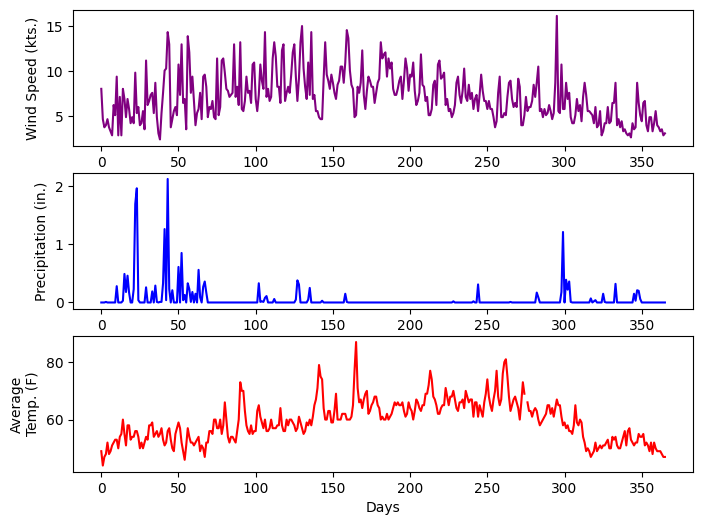

In [75]:
fig = plt.figure(figsize=(8,6))

plt.subplot(3,1,1)
plt.plot(df['AWND'][:366], color='purple')
plt.ylabel('Wind Speed (kts.)')

plt.subplot(3,1,2)
plt.plot(df['PRCP'][:366], color='blue')
plt.ylabel('Precipitation (in.)')

plt.subplot(3,1,3)
plt.plot(df['TAVG'][:366], color='red')
plt.ylabel('Average\nTemp. (F)')
plt.xlabel('Days')

plt.show()

## Your Task
In the coding blocks below, your task is to create a Recurrent Neural Network that can predict the next 7 days of wind, precipitation, and temperature. Your model should take in a tensor with 30 days of data as shown in the example below.

For this competition, Mike will take everyone's trained models and make predictions. To score the predictions, he will compute the mean square errors of your model predictions and the real weather *one week after the homework assignment is due*. The best weather model will win a small prize. Note that you are graded on the steps in the creation of your model, not how well your model predicts that real weather.

#### Precautions
- This is a real dataset from the wild. This means that there will be missing data and bad values. Be sure to remove days without data or with bad values. Plotting the data will help to identify these periods.

This dataset has data from almost every day from 2000 up until present day -> we can limit to 10 years like in the lecture example

In [76]:
df_cleaned = df[['AWND', 'PRCP', 'TAVG']].copy()
df_cleaned = df_cleaned.dropna()

def create_sequences(data, n_previous_days=30, n_future_days=7):
    X, y = [], []
    for i in range(len(data) - n_previous_days - n_future_days):
        X.append(data[i:i+n_previous_days])
        y.append(data[i+n_previous_days:i+n_previous_days+n_future_days])
    
    X = np.stack(X)
    y = np.stack(y)
    y = y.reshape(len(y), -1)  # Flatten y to shape (num_samples, n_future_days * num_features)
    print(np.shape(X), np.shape(y))
    return X, y

weather_data = df_cleaned.values.astype(np.float32)
mean_vals = np.mean(weather_data, axis=0)
std_vals = np.std(weather_data, axis=0)
weather_normalized = (weather_data - mean_vals) / std_vals

print("Normalization parameters:")
print(f"Wind - Mean: {mean_vals[0]:.10f}, Std: {std_vals[0]:.10f}")
print(f"Precipitation - Mean: {mean_vals[1]:.10f}, Std: {std_vals[1]:.10f}")
print(f"Temperature - Mean: {mean_vals[2]:.10f}, Std: {std_vals[2]:.10f}")

n_previous_days = 30
n_future_days = 7

X, y = create_sequences(weather_normalized, n_previous_days, n_future_days)

Normalization parameters:
Wind - Mean: 6.9938979149, Std: 2.6764986515
Precipitation - Mean: 0.0420370363, Std: 0.1736241132
Temperature - Mean: 59.4234771729, Std: 7.0130538940
(6497, 30, 3) (6497, 21)


Now we can prepare the training sequences

In [77]:
# split the data in train and test splits
split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

In [78]:
X_train_tensor = torch.tensor(X_train).float()
X_test_tensor = torch.tensor(X_test).float()
y_train_tensor = torch.tensor(y_train).float()
y_test_tensor = torch.tensor(y_test).float()
print(X_test_tensor.shape)

batch_size = 16

ds_train = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=False)

ds_test = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=False)

torch.Size([1300, 30, 3])


In [79]:
class WeatherLSTM(nn.Module):
    def __init__(self, n_future_days, input_size=3, hidden_size=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, n_future_days * 3)  # 3 features: temp, wind, precip

    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]  # Take the output of the last time step
        return self.fc(last)

In [80]:
model = WeatherLSTM(n_future_days=7).to(device)

In [81]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [82]:
EPOCHS = 20

train_losses = []
test_losses = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            pred = model(xb)
            loss = criterion(pred, yb)
            test_loss += loss.item() * xb.size(0)

    n_train, n_test = len(train_loader.dataset), len(test_loader.dataset)
    train_losses.append(train_loss / n_train)
    test_losses.append(test_loss / n_test)

    print(f"Epoch {epoch:03d} | train MSE: {train_loss/n_train:.6f} | test MSE: {test_loss/n_test:.6f}")


Epoch 001 | train MSE: 0.729435 | test MSE: 0.937460
Epoch 002 | train MSE: 0.657257 | test MSE: 0.897042
Epoch 003 | train MSE: 0.646625 | test MSE: 0.886751
Epoch 004 | train MSE: 0.640892 | test MSE: 0.883100
Epoch 005 | train MSE: 0.636404 | test MSE: 0.879235
Epoch 006 | train MSE: 0.632928 | test MSE: 0.875723
Epoch 007 | train MSE: 0.630127 | test MSE: 0.872681
Epoch 008 | train MSE: 0.628040 | test MSE: 0.871358
Epoch 009 | train MSE: 0.626422 | test MSE: 0.871258
Epoch 010 | train MSE: 0.624822 | test MSE: 0.871609
Epoch 011 | train MSE: 0.623315 | test MSE: 0.872053
Epoch 012 | train MSE: 0.621846 | test MSE: 0.872610
Epoch 013 | train MSE: 0.620509 | test MSE: 0.873163
Epoch 014 | train MSE: 0.619032 | test MSE: 0.873549
Epoch 015 | train MSE: 0.617331 | test MSE: 0.873572
Epoch 016 | train MSE: 0.616136 | test MSE: 0.874784
Epoch 017 | train MSE: 0.614850 | test MSE: 0.875213
Epoch 018 | train MSE: 0.612375 | test MSE: 0.875194
Epoch 019 | train MSE: 0.609970 | test MSE: 0.

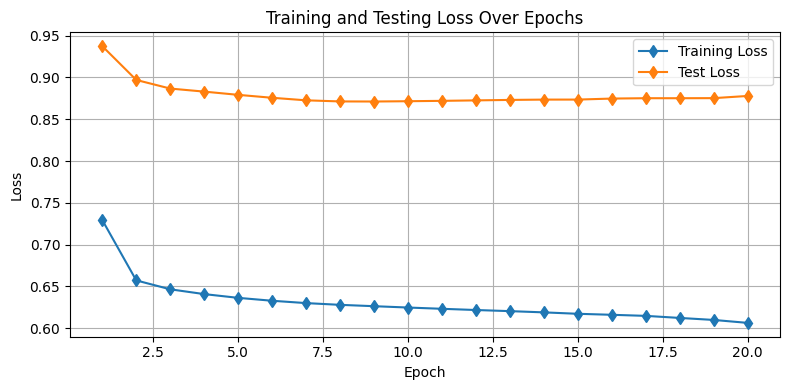

In [83]:
plt.figure(figsize=(8, 4))
plt.plot(range(1, EPOCHS + 1), train_losses, 'd-', label='Training Loss')
plt.plot(range(1, EPOCHS + 1), test_losses, 'd-', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Saving Your Model
When you are done with your model, save a copy so that Mike can run your model. You can save a model by storing the architecture of the class in a `.py` file and then storing the weights of your model with PyTorch as a pickle file:

In [84]:
# first, save your model class as a .py file
# e.g. WeatherRNN.py

In [85]:
# then, save the parameters of your model with the following
torch.save(model.state_dict(), 'WeatherRNN')

## Instructions for Running Your Model
To test your model, Mike is going to need to know how to use it! Here is an example dataset, model and set of instructions to see how this section should operate. You should update this section depending on the creation of your model:

In [86]:
# read in the test data
# this data will be replaced with real data
# one week after the assignment due data
test_data = np.float32(np.fromfile('Test_Weather_Data','>f4').reshape((1,30,3)))

# read in the model
from WeatherRNN import WeatherLSTM
model = WeatherLSTM(n_future_days=7, input_size=3).to(device)
state_dict = torch.load('WeatherRNN', map_location=torch.device(device))
model.load_state_dict(state_dict)
model.eval()

WeatherLSTM(
  (lstm): LSTM(3, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=21, bias=True)
)

#### Example Instructions
To use my model, first normalize the data with the following parameters:

In [87]:
mean_wind = 6.8980833561831645
std_wind = 2.6510546453888635
mean_precip = 0.04209761447765287
std_precip = 0.18175956032782356
mean_temp = 59.39490271307208
std_temp = 6.926738442509242

In [88]:
# normalize
test_data_normalized = test_data.copy()
test_data_normalized[:,:,0] -= mean_wind
test_data_normalized[:,:,0] /= std_wind
test_data_normalized[:,:,1] -= mean_precip
test_data_normalized[:,:,1] /= std_precip
test_data_normalized[:,:,2] -= mean_temp
test_data_normalized[:,:,2] /= std_temp

# convert to a tensor
test_data_tensor = torch.tensor(test_data_normalized).float().to(device)

Then, pass the data to the model to make a forecast:

In [89]:
forecast = model(test_data_tensor).to(device)

In [90]:
forecast = forecast.cpu().detach().numpy()

forecast = forecast.reshape(1, 7, 3)

To make a forecast of absolute values, de-normalize the data:

In [91]:
forecast[:,:,0] *= std_wind
forecast[:,:,0] += mean_wind
forecast[:,:,1] *= std_precip
forecast[:,:,1] += mean_precip
forecast[:,:,2] *= std_temp
forecast[:,:,2] += mean_temp

Then, plot everything to visualize the forecast:

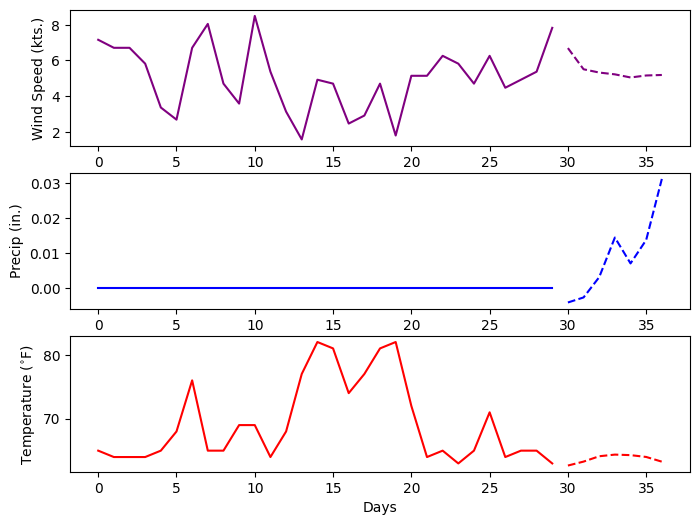

In [92]:
fig = plt.figure(figsize=(8,6))

plt.subplot(3,1,1)
plt.plot(test_data[0,:,0], color='purple')
plt.plot(np.arange(30,37), forecast[0,:,0], '--', color='purple')
plt.ylabel('Wind Speed (kts.)')

plt.subplot(3,1,2)
plt.plot(test_data[0,:,1], color='blue')
plt.plot(np.arange(30,37), forecast[0,:,1], '--', color='blue')
plt.ylabel('Precip (in.)')

plt.subplot(3,1,3)
plt.plot(test_data[0,:,2], color='red')
plt.plot(np.arange(30,37), forecast[0,:,2], '--', color='red')
plt.ylabel('Temperature ($^{\\circ}$F)')
plt.xlabel('Days')
plt.show()

You should update these demo instructions as necessary for your model.